# Exercise 3
Ole Gunnar Hovland, Jan Haakon Trabski and Alexander Hatle

In [190]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 12}
from matplotlib import cm
plt.rcParams.update(newparams)

In [187]:
# Handed out code
def plot_solution(x, t, U, txt='Solution'):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    T, X = np.meshgrid(t,x)
    # ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt);

# Modified to take in vectors
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = np.diag(v * e[1:],-1) + np.diag(d * e) + np.diag(w *e[1:],1)
    return A

In [151]:
def CN(g, f, BCs, params, M, N, R, T):
    """Crank-Nicholson method to solve the Black-Scholes PDE

    Args:
        g (function): initial function for t=0
        f (function): RHS
        BCs (list): _list of two arrays with Dirichlet conds, first is at x = 0, second at x = R
        params (list):     a list containing parameters: sigma, r, c and K   
        M (int): number of grid points in x-direction    
        N (int): number of grid points in t-direction   
        R (float): end of x
        T (float): end of integration

    Returns:
        x, t: the gridpoints in the x- and t- directions 
        U: An array with the numerical solution.
    """

    # Set the stepsizes
    h = R/M     # Stepsize in space
    k = T/N     # Stepsize in time

    # Parameters
    sigma = params[0]
    r = params[1]
    c = params[2]
    K = params[3]

    # Helping parameters
    alpha = sigma**2 * k / (4 * h**2)
    beta = r * k / (4*h)
    gamma = c * k / 2

    # Print the stepsizes, and r=k/h^2.
    #print('h={:.4f}, k={:.4f}'.format(h,k))

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:, 0] = g(x)              # Initial values, endpoints included

    # Boundary
    U[0, :] = BCs[0]
    U[-1, :] = BCs[1]
    
    # Constructing C
    lowdiag = -alpha * x[2:-1]**2 - beta * x[2:-1]         # M-2
    diag =  2 * alpha * x[1:-1]**2 + gamma                 # M-1
    updiag = -alpha * x[1:-2]**2 + beta * x[1:-2]          # M-2
    C = tridiag(lowdiag, diag, updiag, M-1)

    # Constructing A and B
    A = np.eye(M-1) + C
    B = np.eye(M-1) - C
    

    # Constructing p and q
    p = np.zeros(M-1)
    q = np.zeros(M-1)
    
    # Main loop 
    for n in range(N):
        # Updating p and q
        p[0] = (-alpha * x[1]**2 - beta * x[1]) * U[0,n+1]
        p[-1] = (-alpha * x[-2]**2 + beta * x[-2]) * U[-1,n+1]
        q[0] = (alpha * x[1]**2 + beta * x[1]) * U[0,n]
        q[-1] = (alpha * x[-2]**2 - beta * x[-2]) * U[-1,n]

        # Solving linear system
        tempvec = B.dot(U[1:-1, n]) + q - p + k * (f(x, t[n]) + f(x, t[n+1]))/2
        U[1:-1, n+1] = np.linalg.solve(A, tempvec)  # [1:-1] -> excluding endpoints
    return x, t, U

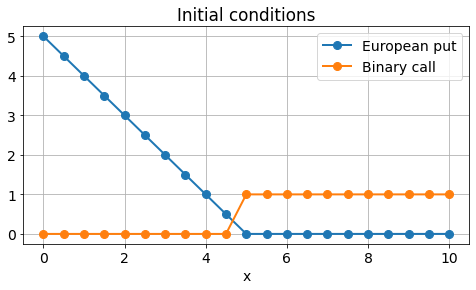

In [178]:
def european_put(x, K):
    sol = K-x
    sol[sol < 0] = 0
    return sol
def binary_call(x, K):
    sol = x-K
    sol[sol >= 0] = 1
    sol[sol < 0] = 0
    return sol

# Plot initial conditions
x = np.linspace(0, 10, 21)
K = 5
plt.title('Initial conditions')
plt.plot(x, european_put(x, K), '-o', label = 'European put')
plt.plot(x, binary_call(x, K), '-o', label = 'Binary call')
plt.xlabel('x')
plt.legend()
plt.show()

50


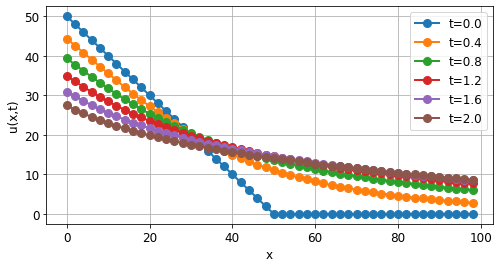

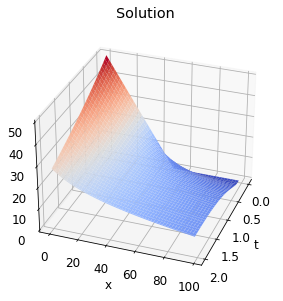

In [288]:
# Grid parameters
T = 2
R = 200
M = 100
N = 100
x = np.linspace(0,R,M+1)
t = np.linspace(0,T,N+1)

# Parameters
sigma = 1
r = 0.01
c = 0.3
K = 50
params = [sigma, r, c, K]

# Initial conditions
init = 'EP'                         # Change this line to change initial condition
if init == 'binary':
    def g(x):                       # u(x, 0)
        return binary_call(x, K)
    BC0 = 0 * t                     # u(0, t)

    # Plotting variables for later
    plot_from = int(K*M/R * 0.5)
    plot_to = int(K*M/R * 1.5)
    
elif init == 'EP':
    def g(x):                       # u(x, 0)
        return european_put(x, K)
    BC0 = K * np.exp(-c * t)        # u(0, t)
    # Plotting variables for later
    plot_from = 0
    plot_to = int(K*M/R * 2)
    print(plot_to)
    
BCR = g(np.repeat(R, N+1))          # u(R, t) = u(R, 0)
BCs = [BC0, BCR]

def f(x, t):                        # RHS
    return 0 * t

x, t, U = CN(g, f, BCs, params, M, N, R, T)

# Plotting
plt.figure(1)
plt.clf()
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    plt.plot(x[plot_from:plot_to],U[plot_from:plot_to,n],'-o',label='t={:.1f}'.format(tn))
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.show()
# Make a 3-d plot
plot_solution(x[plot_from:plot_to], t, U[plot_from:plot_to, :], txt='Solution')


# 1e)

## Quadratic problem
Since Crank-Nicholson is second order in both space and time, we expect that we will get an exact solution, giving us no error profile. Later we will explore a non-quadratic case.

In [154]:
def u_exact(x, t):
    return (1 + t) * x**2
def u0(x):
    return x**2

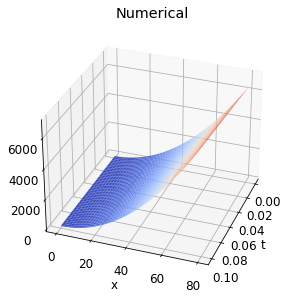

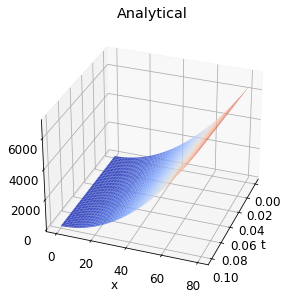

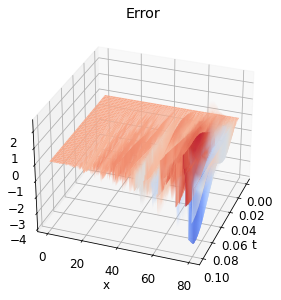

In [284]:
sigma = 0.5
r = 0.2
c = 0.5
K = 10
params = [sigma, r, c, K]

T = 0.1
R = 80
M = 500
N = 500

x = np.linspace(0,R,M+1)
t = np.linspace(0,T,N+1)

def f(x, t):
    return (1+t) * x[1:-1]**2 * (1/(1 + t) - sigma**2 + 2*r + c)

BC0 = 0 * t
BCR = R**2 * (1 + t)
BCs = [BC0, BCR]


x, t, U = CN(u0, f, BCs, params, M, N, R, T)

plot_solution(x, t, U, txt = 'Numerical')
tt, xx = np.meshgrid(t, x)
plot_solution(x, t, u_exact(xx, tt), txt = 'Analytical')
plot_solution(x, t, U - u_exact(xx, tt), txt = 'Error')

In [169]:
def error_analysis(g, f, boundary, exact, params, Ms, Ns, R, T):
    """
    Iterate through either Ms or Ns (one of these arrays should only have one element) and compute U.
    Take max norm of the difference between U and exact solution
    Args:
        g (funtion): initial condition u(x, 0)
        f (function): RHS
        boundary (function): see docstring. Returns list of two arrays for boundary conditions
        exact (function): exact solution
        params (_type_): list of parameters (sigma, r, c, K)
        Ms (array): values of M
        Ns (array): values of N
        R (float): _description_
        T (float): _description_

    Returns:
        error (array): error values for different M or N
    """
    i = 0
    error = np.zeros(max(Ms.size, Ns.size))
    for M in Ms:
        for N in Ns:
            t = np.linspace(0,T,N+1)
            BCs = boundary(t)
            x, t, U = CN(g, f, BCs, params, M, N, R, T)
            tt, xx = np.meshgrid(t, x)
            error[i]= np.max(np.abs(exact(x, t[-1]) - U[:,-1]))
            i += 1
    return error

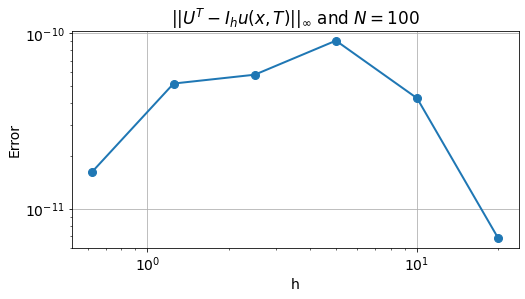

In [170]:
T = 0.1
R = 80
N = 100
Ns = np.array([N])
numpoints = 6                   
Ms = 2**(np.arange(2, numpoints + 2))     
hs = R / Ms

sigma = 0.1
r = 0.2
c = 0.5
K = 10
params = [sigma, r, c, K]

def f(x, t):
        # RHS
        return (1+t) * x[1:-1]**2 * (1/(1 + t) - sigma**2 + 2*r + c)

def boundary(t):
        # Boundary values.
        # BC0: u(0, t).         BCR: u(R, t)
        BC0 = 0 * t
        BCR = R**2 * (1 + t)
        BCs = [BC0, BCR]
        return BCs
        
error_h = error_analysis(u0, f, boundary, u_exact, params, Ms, Ns, R, T)

plt.figure(0)
plt.loglog(hs, error_h, '-o')
plt.xlabel('h')
plt.ylabel('Error')
plt.title(r'$||U^T-I_hu(x,T)||_\infty$ and ' + rf'$N={N}$')
plt.show()

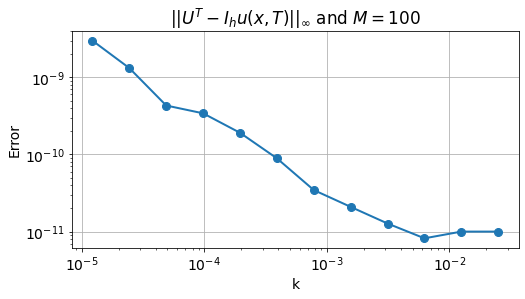

In [171]:
# Cell above needs to be run before this cell
num = 12
Ns = 2**np.arange(2, num + 2)
ks = T/Ns
num = 6
M = 100
Ms = np.array([M])

error_k = error_analysis(u0, f, boundary, u_exact, params, Ms, Ns, R, T)

plt.figure(0)
plt.loglog(ks, error_k, '-o')
plt.xlabel('k')
plt.ylabel('Error')
plt.title(r'$||U^T-I_hu(x,T)||_\infty$ and ' + rf'$M={M}$')
plt.show()

The error seems to decrease when step sizes increase, which does not make sense. Our hypothesis is with that larger stepsizes, we don't actually record the largest error each time. Maybe we would have gotten constant error with another norm?

## Non-quadratic problem

In [172]:
def u2_exact(x, t):
    return np.sin(np.pi * x / R) * np.exp(-t)

def u2_0(x):
    return np.sin(np.pi * x / R)

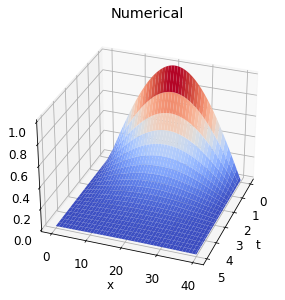

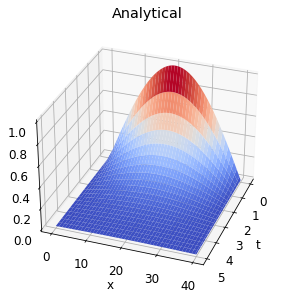

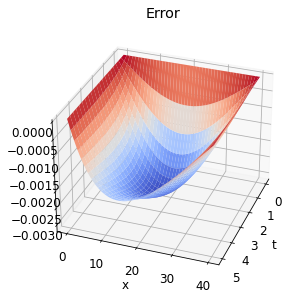

In [281]:
sigma = 0.5
r = 0.01
c = 0.03
K = 10
params = [sigma, r, c, K]

T = 5
R = 40
M = 400
N = 20

x = np.linspace(0,R,M+1)
t = np.linspace(0,T,N+1)

def f(x, t):
    return np.sin(np.pi * x[1:-1] / R) * np.exp(-t) * (-1 + (np.pi * sigma * x[1:-1] / R)**2 / 2 + c) \
        + (r * x[1:-1] * np.pi / R) * np.cos(np.pi * x[1:-1] / R) * np.exp(-t)

BC0 = 0 * t
BCR = 0 * t
BCs = [BC0, BCR]

x, t, U = CN(u2_0, f, BCs, params, M, N, R, T)

plot_solution(x, t, U, txt = 'Numerical')
tt, xx = np.meshgrid(t, x)
plot_solution(x, t, u2_exact(xx, tt), txt = 'Analytical')
plot_solution(x, t, U - u2_exact(xx, tt), txt = 'Error')

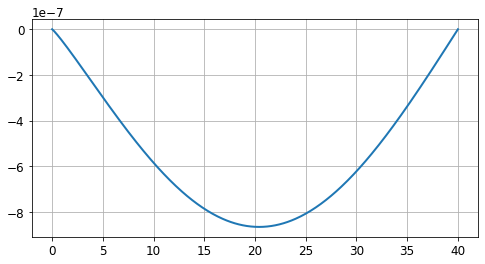

In [272]:
# Error is in magnitude 1e-7, as shown here: (magnitude is hidden in the plot above for some reason?) 
plt.plot(x, U[:,-1] - u2_exact(xx, tt)[:,-1])

### As function of $h$ and $k$

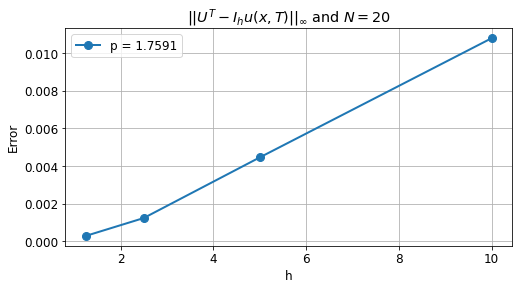

In [277]:
T = 0.5
R = 40
N = 20
Ns = np.array([N])
numpoints = 4
Ms = 2**(np.arange(2, numpoints + 2))     
hs = R / Ms

k = T/N



sigma = 0.1
r = 0.2
c = 0.5
K = 10
params = [sigma, r, c, K]

def f(x, t):
    #return 3 * (1 + t**3) * x[1:-1]**3 * (t**2/(1 + t**3) - sigma**2 + r + c/3)
    return np.sin(np.pi * x[1:-1] / R) * np.exp(-t) * (-1 + (np.pi * sigma * x[1:-1] / R)**2 / 2 + c) \
        + (r * x[1:-1] * np.pi / R) * np.cos(np.pi * x[1:-1] / R) * np.exp(-t)

def boundary(t):
    BC0 = 0 * t
    BCR = 0 * t
    BCs = [BC0, BCR]
    return BCs

#error_h = error_analysis(u2_0, u2_exact, Ms, Ns, R, T, crank_modified_again, params)
error_h = error_analysis(u2_0, f, boundary, u2_exact, params, Ms, Ns, R, T)

order = np.polyfit(np.log(hs),np.log(error_h), 1)[0]



plt.figure(0)
plt.plot(hs, error_h, '-o', label = 'p = {:.4f}'.format(order))
plt.xlabel('h')
plt.ylabel('Error')
plt.title(r'$||U^T-I_hu(x,T)||_\infty$ and ' + rf'$N={N}$')
plt.legend()
plt.show()

[2600.  1300.   650.   325.   162.5]
[5000.  2500.  1250.   625.   312.5]


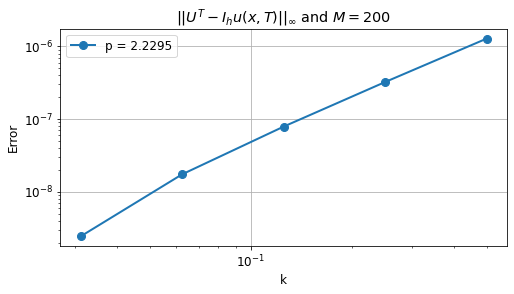

In [279]:
T = 1
R = 40
num = 5    
Ns = 2**np.arange(1, num+1)
M = 200               
Ms = np.array([M])
ks = T / Ns
h = R/M

sigma = 0.1
r = 0.2
c = 10000
K = 10
params = [sigma, r, c, K]

error_k = error_analysis(u2_0, f, boundary, u2_exact, params, Ms, Ns, R, T)
order = np.polyfit(np.log(ks),np.log(error_k), 1)[0]

cfl = ks/2 * (sigma**2 / h**2 * R**2 + c)
print(cfl)
print(ks*c)

plt.figure(0)
plt.loglog(ks, error_k, '-o', label = 'p = {:.4f}'.format(order))
plt.xlabel('k')
plt.ylabel('Error')
plt.title(r'$||U^T-I_hu(x,T)||_\infty$ and ' + rf'$M={M}$')
plt.legend()
plt.show()

## 1f)

In [291]:
def EP_BC(M, N, R, T, init, K):
    x = np.linspace(0,R,M+1)
    t = np.linspace(0,T,N+1)

    # Parameters
    sigma = 1
    r = 0.8
    c = 0.2
    K = 10
    params = [sigma, r, c, K]

    # Initial conditions
    
    if init == 'binary':
        def g(x):                       # u(x, 0)
            return binary_call(x, K)
        BC0 = 0 * t                     # u(0, t)
    elif init == 'EP':
        def g(x):                       # u(x, 0)
            return european_put(x, K)
        BC0 = K * np.exp(-c * t)        # u(0, t)
        
    BCR = g(np.repeat(R, N+1))          # u(R, t) = u(R, 0)
    BCs = [BC0, BCR]

    def f(x, t):                        # RHS
        return 0 * t

    x, t, U = CN(g, f, BCs, params, M, N, R, T)
    return x[:int(K*M/R * 2)], t, U[:int(K*M/R * 2), -1]


In [290]:
# Grid parameters
T = 2
R = 80
M = 2000
N = 2000
K = 10
x, t, U_refined = EP_BC(M, N, R, T, 'EP', K)

In [ ]:
Rs = np.arange(2.01*K, 10*K+1, K)
error_R = np.zeros(Rs.shape)
for R in Rs:
    x, t, U_refined

### old functions

In [166]:
def crank(g, params, BC, M=10, N=100, R = 1, T=0.5):
    # Input: 
    #       g: initial function for t=0
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of integration
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.

    

    # Set the stepsizes
    h = R/M     # Stepsize in space
    k = T/N     # Stepsize in time

    # Parameters
    sigma = params[0]
    r = params[1]
    c = params[2]
    K = params[3]

    # Helping parameters
    alpha = sigma**2 * k / (4 * h**2)
    beta = r * k / (4*h)
    gamma = c * k / 2

    # Print the stepsizes, and r=k/h^2.
    print('h={:.4f}, k={:.4f}'.format(h,k))

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x, K)              # Initial values, endpoints included
    
    # Constructing C
    lowdiag = -alpha * x[2:-1]**2 - beta * x[2:-1]         # M-2
    diag =  2 * alpha * x[1:-1]**2 + gamma                 # M-1
    updiag = -alpha * x[1:-2]**2 + beta * x[1:-2]          # M-2
    C = tridiag(lowdiag, diag, updiag, M-1)

    # Constructing A and B
    A = np.eye(M-1) + C
    B = np.eye(M-1) - C

    # Boundary functions, bnddry0 = u(0, t), bndryR = u(R, t)
    if BC == 'EP':
        U[0, :] = K * np.exp(-c * t)
    elif BC == 'binary':
        U[0, :] = 0 * t
    
    # u(R,t) = u(R, 0)
    U[-1, :] = np.repeat(U[-1, 0], N+1)

    # Constructing p and q
    p = np.zeros(M-1)
    q = np.zeros(M-1)
    

    # Main loop 
    for n in range(N):
        # Updating p and q
        p[0] = (-alpha * x[1]**2 - beta * x[1]) * U[0,n+1]
        p[-1] = (-alpha * x[-2]**2 + beta * x[-2]) * U[-1,n+1]
        q[0] = (alpha * x[1]**2 + beta * x[1]) * U[0,n]
        q[-1] = (alpha * x[-2]**2 - beta * x[-2]) * U[-1,n]

        # Solving linear system
        U[1:-1, n+1] = np.linalg.solve(A, B.dot(U[1:-1, n]) + q - p )  # [1:-1] -> excluding endpoints
    return x, t, U

In [167]:
def crank_modified(g, params, M=10, N=100, R = 1, T=0.5):
    # Input: 
    #       g: initial function for t=0
    #       params: a list containing parameters
    #               sigma, r, c and K
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of integration
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.

    

    # Set the stepsizes
    h = R/M     # Stepsize in space
    k = T/N     # Stepsize in time

    # Parameters
    sigma = params[0]
    r = params[1]
    c = params[2]
    K = params[3]

    # Helping parameters
    alpha = sigma**2 * k / (4 * h**2)
    beta = r * k / (4*h)
    gamma = c * k / 2

    # Print the stepsizes, and r=k/h^2.
    print('h={:.4f}, k={:.4f}'.format(h,k))

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x)              # Initial values, endpoints included

    # Boundary
    U[0, :] = 0
    U[-1, :] = R**2 * (1 + t)
    
    # Constructing C
    lowdiag = -alpha * x[2:-1]**2 - beta * x[2:-1]         # M-2
    diag =  2 * alpha * x[1:-1]**2 + gamma                 # M-1
    updiag = -alpha * x[1:-2]**2 + beta * x[1:-2]          # M-2
    C = tridiag(lowdiag, diag, updiag, M-1)

    # Constructing A and B
    A = np.eye(M-1) + C
    B = np.eye(M-1) - C

    # Boundary functions, bnddry0 = u(0, t), bndryR = u(R, t)
    

    # Constructing p and q
    p = np.zeros(M-1)
    q = np.zeros(M-1)
    # RHS
    def f(t):
        return (1+t) * x[1:-1]**2 * (1/(1 + t) - sigma**2 + 2*r + c)

    # Main loop 
    for n in range(N):
        # Updating p and q
        p[0] = (-alpha * x[1]**2 - beta * x[1]) * U[0,n+1]
        p[-1] = (-alpha * x[-2]**2 + beta * x[-2]) * U[-1,n+1]
        q[0] = (alpha * x[1]**2 + beta * x[1]) * U[0,n]
        q[-1] = (alpha * x[-2]**2 - beta * x[-2]) * U[-1,n]

        tempvec = B.dot(U[1:-1, n]) + q - p + k * (f(t[n]) + f(t[n+1]))/2
        U[1:-1, n+1] = np.linalg.solve(A, tempvec)  # [1:-1] -> excluding endpoints
        
    return x, t, U

In [168]:
def crank_modified_again(g, params, M=10, N=100, R = 1, T=0.5):
    # Input: 
    #       g: initial function for t=0
    #       params: a list containing parameters
    #               sigma, r, c and K
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of integration
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.

    

    # Set the stepsizes
    h = R/M     # Stepsize in space
    k = T/N     # Stepsize in time

    # Parameters
    sigma = params[0]
    r = params[1]
    c = params[2]
    K = params[3]

    # Helping parameters
    alpha = sigma**2 * k / (4 * h**2)
    beta = r * k / (4*h)
    gamma = c * k / 2

    # Print the stepsizes, and r=k/h^2.
    print('h={:.4f}, k={:.4f}'.format(h,k))
    print('r={:.4f}, h*sigma^2={:.4f}'.format(r, h * sigma**2))

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x)              # Initial values, endpoints included

    # Boundary
    U[0, :] = 0
    U[-1, :] = 0 #x[-1]**3 * (1 + t**3)
    
    # Constructing C
    lowdiag = -alpha * x[2:-1]**2 - beta * x[2:-1]         # M-2
    diag =  2 * alpha * x[1:-1]**2 + gamma                 # M-1
    updiag = -alpha * x[1:-2]**2 + beta * x[1:-2]          # M-2
    C = tridiag(lowdiag, diag, updiag, M-1)

    # Constructing A and B
    A = np.eye(M-1) + C
    B = np.eye(M-1) - C

    # Boundary functions, bnddry0 = u(0, t), bndryR = u(R, t)
    

    # Constructing p and q
    p = np.zeros(M-1)
    q = np.zeros(M-1)

    
    # RHS
    def f(t):
        #return 3 * (1 + t**3) * x[1:-1]**3 * (t**2/(1 + t**3) - sigma**2 + r + c/3)
        return np.sin(np.pi * x[1:-1] / R) * np.exp(-t) * (-1 + (np.pi * sigma * x[1:-1] / R)**2 / 2 + c) \
            + (r * x[1:-1] * np.pi / R) * np.cos(np.pi * x[1:-1] / R) * np.exp(-t)
        

    # Main loop 
    for n in range(N):
        # Updating p and q
        p[0] = (-alpha * x[1]**2 - beta * x[1]) * U[0,n+1]
        p[-1] = (-alpha * x[-2]**2 + beta * x[-2]) * U[-1,n+1]
        q[0] = (alpha * x[1]**2 + beta * x[1]) * U[0,n]
        q[-1] = (alpha * x[-2]**2 - beta * x[-2]) * U[-1,n]

        tempvec = B.dot(U[1:-1, n]) + q - p + k * (f(t[n]) + f(t[n+1])) / 2
        U[1:-1, n+1] = np.linalg.solve(A, tempvec)  # [1:-1] -> excluding endpoints
        
    return x, t, U